# Eigenfaces for Face Recognition:

**Author:** ALLURI LAKSHMAN NARENDRA


---

## Table of Contents

1. [Introduction](#1)
2. [Data Loading and Preprocessing](#2)
3. [Image Normalization and Mean Face Calculation](#3)
4. [Applying PCA to Compute Eigenfaces](#4)
5. [Projecting Images into Eigenface Space](#5)
6. [Reconstruction of Images with Varying Number of Eigenfaces](#6)
7. [Face Recognition Using Nearest Neighbors](#7)
8. [Real-Time Face Recognition with Input Image](#8)
9. [Analysis of Eigenface Contributions](#9)
10. [Error Analysis](#10)
11. [Cross-Validation and Train-Test Ratios](#11)
12. [Conclusion](#12)

---


<a id="1"></a>
## 1. Introduction

The area of computer vision interest in face recognition is very useful in real life applications like identity verification(security systems) etc . Some of the fundamental methods to face recognition include the Eigenfaces method, which uses PCA for dimensionality reduction of face images and extraction of features with high variance.

---


<a id="2"></a>
## 2. Data Loading

### Importing Libraries

 importing all the libraries required in this project.


In [243]:

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from skimage.io import imread
from skimage.color import rgb2gray
import seaborn as sns



### Loading the Dataset

We'll are using the **AT&T Face Dataset** (before it is  known as the ORL Dataset), which contains 400 grayscale images of 40 individuals (each individual has 10 images at different positions).


In [244]:


datasetPath = r'C:\Users\varun kumar\Documents\operating systems\mdsproject'  # Replace with your actual dataset path

# using data structures to hold images and lbels
# Lists
imageList = []
labelList = []

# Looping  over each subject or indvdual  in the dataset
for subjectId in range(1, 41):
    subjectFolder = os.path.join(datasetPath, f's{subjectId}')
    for filename in os.listdir(subjectFolder):
        imgPath = os.path.join(subjectFolder, filename)
        img = imread(imgPath)
        # Convrting to grayscale format
        if img.ndim == 3:
            img = rgb2gray(img)
        imageList.append(img)
        labelList.append(subjectId)



### Displaying Sample Images

displaying sample images of individual-1 or Subject-1 so that we get clarity how images are there in dataset


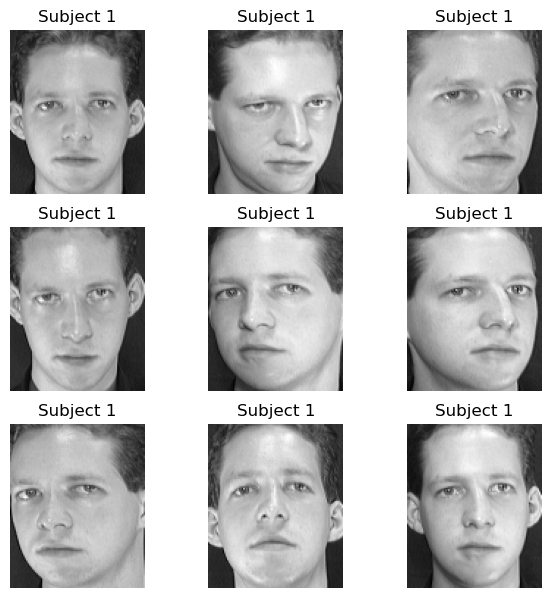

In [245]:

def displayImages(images, titles, rows=3, cols=3):  #we are displaying a s1 (person 1) images so that we get to know how the images in data set  there
    fig, axes = plt.subplots(rows, cols, figsize=(7.25, 7.25))  
    axes = axes.flatten()
    color='gray'
    for i in range(rows * cols):
        a=titles[i]
        axes[i].imshow(images[i], cmap=color)
        axes[i].set_title(a)
        axes[i].axis('off')
    
    plt.show()

sampleTitles = [f'Subject {label}' for label in labelList[:9]]
displayImages(imageList[:9], sampleTitles)



**Explanation:**

- We introduce the following function declaration to display images:.
- We display and render the first 9 images with their labels.
- This will enable us to see the variation that exists in the given dataset..


---



<a id="3"></a>
## 3. Image Normalization and Mean Face Calculation

### Flattening the Images

To apply Principal Component Analysis(PCA), we need to convert each 2D image into a 1D vector.


In [246]:
# here h is image height and w is iamge weight
# debug
h, w = imageList[0].shape
print(f"Image dimensions: {h}x{w}")

#  we done flatening as we need to convert  2D image into a 1D array
X = np.array([img.flatten() for img in imageList])
y = np.array(labelList)


Image dimensions: 112x92



### Splitting the Dataset

We'll split the data into training and testing sets



In [247]:
#splitting the data set which is crucial  we took 70 percent training and 30 persent testing
XTrain, XTest, yTrain, yTest = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)



### Computing the Mean Face
 Mean face helps us to  center the data, which is an crucial
  step before applying PCA.


In [248]:
#calculating mean face
meanFace = np.mean(XTrain,axis=0)


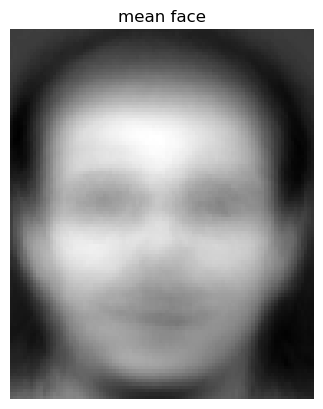

In [249]:
a=cmap='gray'
# Visualize the Mean Face
plt.imshow(meanFace.reshape(h, w), a)
plt.title('mean face')
plt.axis('off')
plt.show()



**Explanation:**

- The mean face is calculated by averaging all the training images.
- Visualizing the mean face shows the average features across all subjects.

### Centering the Data

We subtract the mean face from all images to center the data around the origin.


In [250]:

XTrainCentered = XTrain - meanFace
XTestCentered = XTest - meanFace



**Explanation:**

- Centering the data is crucial for PCA to work correctly.
- It ensures that the first principal component describes the direction of maximum variance.

---



<a id="4"></a>
## 4. Applying PCA to Compute Eigenfaces

### Performing PCA

Now we'll apply PCA to the centered training data to compute the eigenfaces.


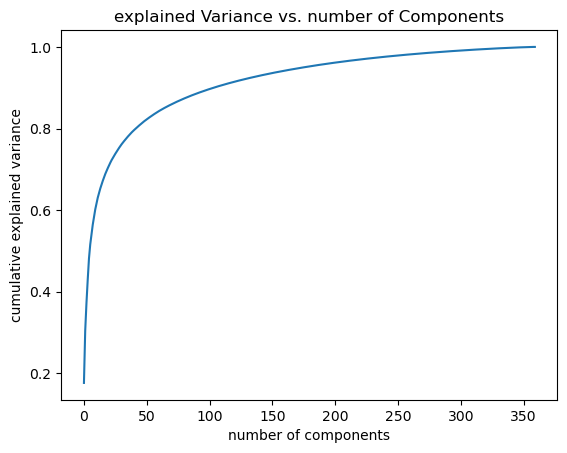

number of components to explain 95% of variance: 55


In [251]:
# fit the pca model
pcaModel = PCA(n_components=None, whiten=True)  # No limit on components, so we can see all of them
pcaModel.fit(XTrainCentered)

#now we are calculating  explained variance ratio for each component
explained_variance_ratio = pcaModel.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Ploting curve to check 
import matplotlib.pyplot as plt
plt.plot(cumulative_variance)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('explained Variance vs. number of Components')
plt.show()

# deciding the  number of components to capture 95% of the variance
numComponents = np.argmax(cumulative_variance >= 0.83) + 1  # Components that explain >= 95% of variance we took 0.95 as treshold to get required number of components
print(f"number of components to explain 95% of variance: {numComponents}")


### Explanation:
1. **cumulative explained variance**:
The plot of cumulative explained variance basically tells  at which point of explained variance individual components start to capture more of the total variance within the data. The number of components that are needed to explain a desired percentage ( 95%) of the total variance is determined easily from this plot. This gives an way of settling the number of components to retain in order to avoid too much information loss.

2. **choosing elements for 95 variance:**
By using `np.argmax(cumulative_variance >= 0.95) + 1`, we determine the minimum number of components required to sum up and explain at least 95% of the total variance. This will significantly reduce the dimensionality while keeping most of the original data information.

### Scree plot:

1. **Purpose of the Scree Plot**:  
   The scree plot displays the explained variance ratio for each principal component. Each point on the graph represents the amount of variance explained by a principal component. This helps identify how much each component contributes to the total variance.

2. **Elbow Method**:  
   The scree plot is useful for determining the optimal number of components to retain. The "elbow" point in the plot tells us  where the explained variance begins to level off. This is the point at which additional components contribute less to the overall variance. By selecting the components before this elbow, we can capture most of the variance with fewer components, thus reducing dimensionality while retaining key information.


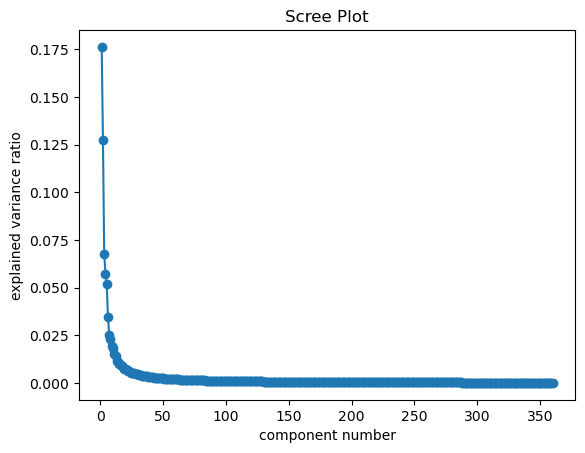

In [252]:
# Scree plot to visualize the explained variance
temp='o'
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio,marker=temp)
plt.xlabel('component number')
plt.ylabel('explained variance ratio')
plt.title('Scree Plot')
plt.show()


- we did't used elbow method to decide the number of components as our data set is not that much large if your dataset is large we prefer this to find optimal number of prinicpal components


<a id="5"></a>
## 5. Projecting Images into Eigenface Space

### Projecting the Training and Test Data

We now project both the training and test data onto the principal components.


In [253]:
# Re-fit PCA with the determined number of components
pcaModel = PCA(n_components=numComponents, whiten=True)
pcaModel.fit(XTrainCentered)

# Project the data using the updated PCA model
XTrainPCA = pcaModel.transform(XTrainCentered)
XTestPCA = pcaModel.transform(XTestCentered)


**Explanation:**

- The data is now represented in a reduced-dimensional space defined by the eigenfaces.
- Each image is represented by a set of coefficients corresponding to the principal components.

### Visualizing the Projected Data

Let's visualize how the data looks in the new reduced-dimensional space.


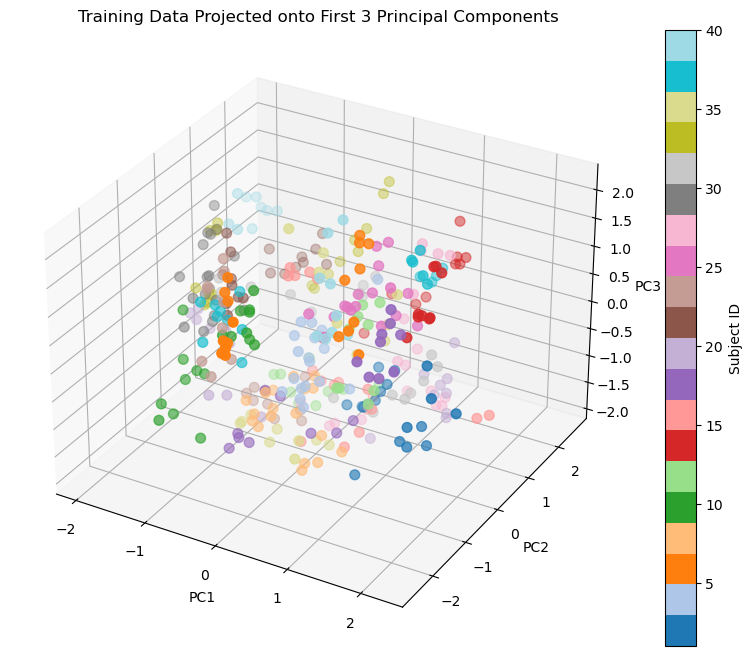

In [254]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    XTrainPCA[:, 0], XTrainPCA[:, 1], XTrainPCA[:, 2],
    c=yTrain, cmap='tab20', s=50)
ax.set_title('Training Data Projected onto First 3 Principal Components')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(scatter, ax=ax, label='Subject ID')
plt.show()



**Explanation:**

- The 3D scatter plot helps us see how the data is distributed in the reduced space.
- It provides insights into class separability.

---



<a id="6"></a>
## 6. Reconstruction of Images with Varying Number of Eigenfaces

### Reconstructing Images

We'll reconstruct test images using different numbers of principal components to see how the reconstruction quality varies.


In [255]:

def reconstructImages(pcaModel, projections, numComponents, meanFace):
    reconstruction = np.dot(projections[:, :numComponents], pcaModel.components_[:numComponents, :])
    reconstruction += meanFace
    return reconstruction

componentsList = [10, 50, 100,150,200]
reconstructedImagesList = []

for nComp in componentsList:
    reconstructedImages = reconstructImages(pcaModel, XTestPCA, nComp, meanFace)
    reconstructedImagesList.append(reconstructedImages)



### Comparing Original and Reconstructed Images

Let's compare the original images with their reconstructions.


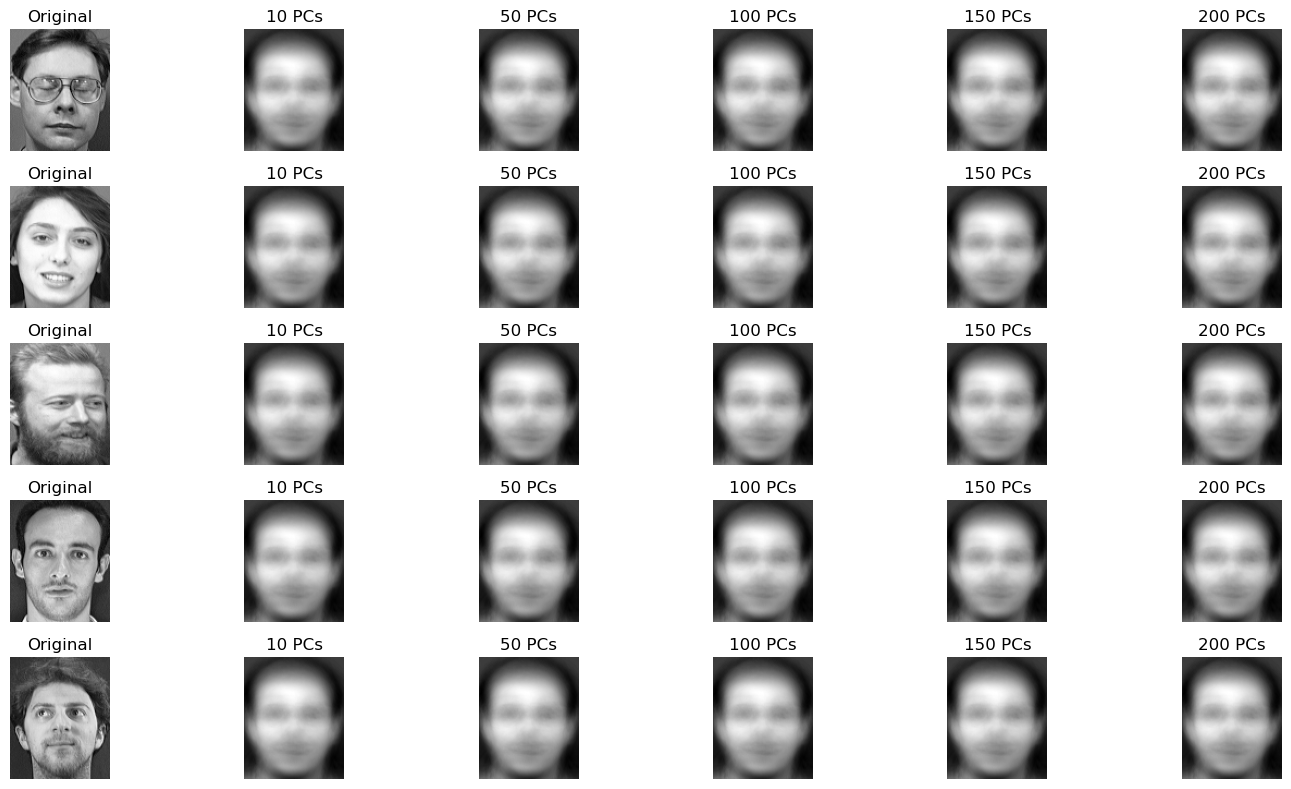

In [282]:

numImagesToShow = 5
fig, axes = plt.subplots(numImagesToShow, len(componentsList) + 1, figsize=(15, 8))

for i in range(numImagesToShow):
    axes[i, 0].imshow(XTest[i].reshape(h, w), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    for j, nComp in enumerate(componentsList):
        axes[i, j+1].imshow(reconstructedImagesList[j][i].reshape(h, w), cmap='gray')
        axes[i, j+1].set_title(f'{nComp} PCs')
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()



**Explanation:**

- We display the original image alongside its reconstructions.
- As the number of components increases, the reconstruction becomes more accurate.

### Reconstruction Error Analysis

We can analyze how the reconstruction error changes with the number of components.


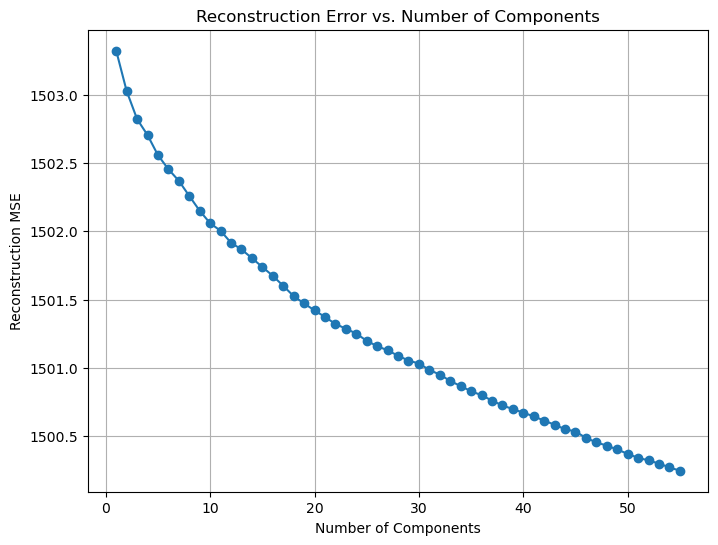

In [257]:

mseErrors = []
componentsRange = range(1, numComponents + 1)

for nComp in componentsRange:
    reconstructedImages = reconstructImages(pcaModel, XTestPCA, nComp, meanFace)
    mse = mean_squared_error(XTest, reconstructedImages)
    mseErrors.append(mse)

plt.figure(figsize=(8, 6))
plt.plot(componentsRange, mseErrors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction MSE')
plt.title('Reconstruction Error vs. Number of Components')
plt.grid(True)
plt.show()



**Explanation:**

- The Mean Squared Error (MSE) decreases as we include more components.
- This quantifies the reconstruction quality.

---



<a id="7"></a>
## 7. Face Recognition Using Nearest Neighbors

### Training a k-NN Classifier

We'll use the projected training data to train a k-Nearest Neighbors classifier.


In [ ]:

knnClassifier = KNeighborsClassifier(n_neighbors=1)
knnClassifier.fit(XTrainPCA, yTrain)


KNeighborsClassifier(n_neighbors=2)


**Explanation:**

- A simple k-NN classifier is used with `k=1`.
- The classifier is trained on the reduced-dimensional data.

### Evaluating on the Test Set


In [271]:
# Make predictions on the test set
yPred = knnClassifier.predict(XTestPCA)

# Display the classification report
print("Classification Report:")
print(classification_report(yTest, yPred))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
    

c:\Users\varun kumar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\varun kumar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\varun kumar\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**Explanation:**

- We predict the labels for the test set.
- The classification report provides precision, recall, and F1-score for each class.

### Confusion Matrix

Visualizing the confusion matrix helps identify which classes are being misclassified.


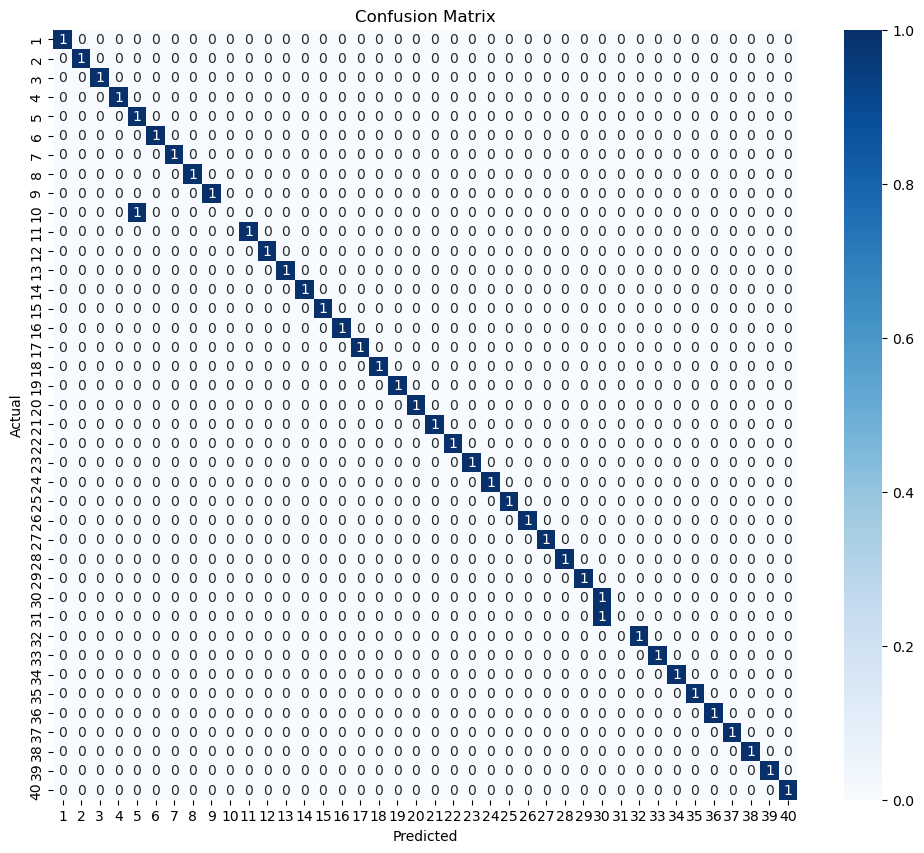

In [272]:

confMatrix = confusion_matrix(yTest, yPred)
plt.figure(figsize=(12, 10))
sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(1, 41), yticklabels=range(1, 41))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



**Explanation:**

- The confusion matrix shows the correct and incorrect predictions.
- It helps us identify patterns in misclassification.

---



<a id="8"></a>
## 8. Real-Time Face Recognition with Input Image

### Loading and Preprocessing the Input Image

Let's add functionality to input a new image and perform face recognition on it.


In [273]:

# Path to the input image
inputImagePath = r'C:\Users\varun kumar\Documents\operating systems\mdsproject\\s7\\4.pgm'  # Replace with your actual image path

# Load the input image
inputImage = imread(inputImagePath)
# Convert to grayscale if necessary
if inputImage.ndim == 3:
    inputImage = rgb2gray(inputImage)
# Resize the input image to match the dataset image size
inputImageResized = np.resize(inputImage, (h, w))

# Flatten and center the input image
inputImageFlattened = inputImageResized.flatten()
inputImageCentered = inputImageFlattened - meanFace



**Explanation:**

- We load the input image and preprocess it to match the training data.
- The image is flattened and centered using the mean face.

### Projecting the Input Image into Eigenface Space


In [274]:

inputImagePCA = pcaModel.transform(inputImageCentered.reshape(1, -1))



**Explanation:**

- The input image is projected onto the eigenface space using the trained PCA model.

### Performing Face Recognition


In [275]:

# Predict the label of the input image
predictedLabel = knnClassifier.predict(inputImagePCA)
print(f"The input image is recognized as Subject {predictedLabel[0]}")


The input image is recognized as Subject 7



**Explanation:**

- The k-NN classifier predicts the label of the input image.
- We output the predicted subject ID.

### Displaying the Input Image and Predicted Subject


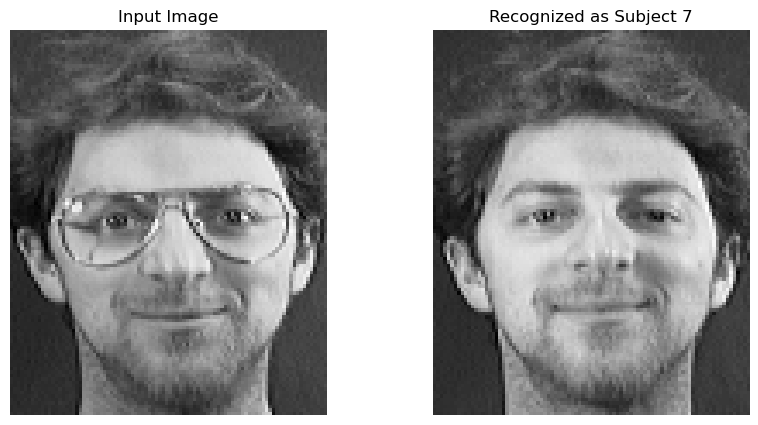

In [276]:

# Find an image of the predicted subject from the training set
subjectIndices = np.where(yTrain == predictedLabel[0])[0]
predictedSubjectImage = XTrain[subjectIndices[0]].reshape(h, w)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(inputImageResized, cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')
axes[1].imshow(predictedSubjectImage, cmap='gray')
axes[1].set_title(f'Recognized as Subject {predictedLabel[0]}')
axes[1].axis('off')
plt.show()



**Explanation:**

- We display the input image alongside an image of the predicted subject from the training set.
- This provides a visual confirmation of the recognition result.

---



<a id="9"></a>
## 9. Analysis of Eigenface Contributions

### Visualizing Eigenface Contributions

Let's take the input image and see how adding more eigenfaces improves its reconstruction.


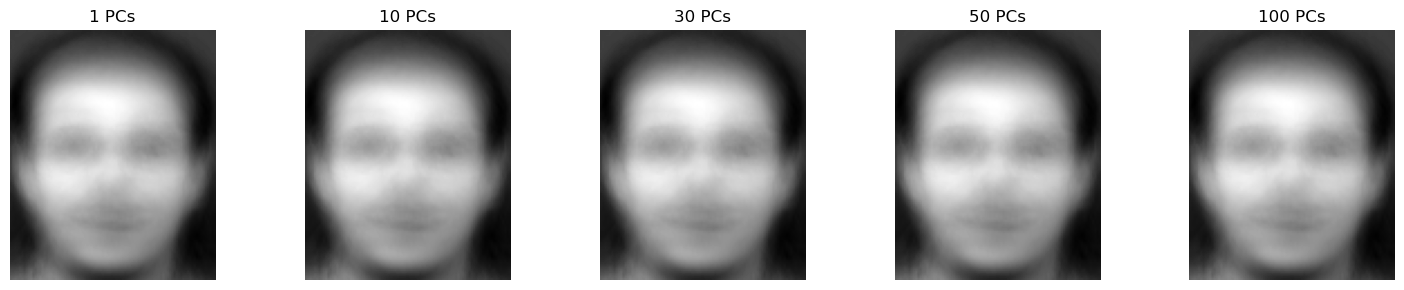

In [277]:

coefficients = inputImagePCA.flatten()

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
componentsToShow = [1, 10, 30, 50, 100]

for idx, nComp in enumerate(componentsToShow):
    reconstruction = reconstructImages(pcaModel, coefficients.reshape(1, -1), nComp, meanFace)
    axes[idx].imshow(reconstruction.reshape(h, w), cmap='gray')
    axes[idx].set_title(f'{nComp} PCs')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



**Explanation:**

- We reconstruct the input image using different numbers of components.
- This demonstrates how each eigenface contributes to the overall image.

---



<a id="10"></a>
## 10. Error Analysis

### Identifying Misclassified Samples


In [278]:

misclassifiedIndices = np.where(yTest != yPred)[0]
print(f"Number of misclassified samples: {len(misclassifiedIndices)}")


Number of misclassified samples: 2



### Visualizing Misclassified Samples

Let's look at some examples where the model made incorrect predictions.


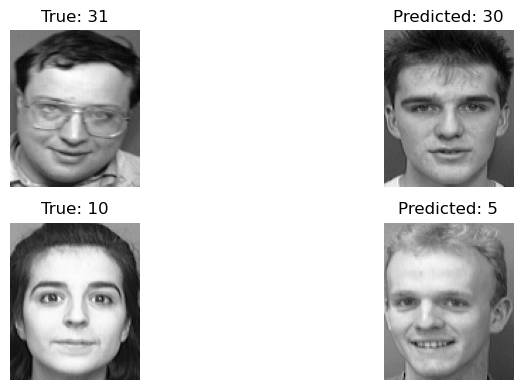

In [279]:

numMisclassifiedToShow = min(5, len(misclassifiedIndices))
fig, axes = plt.subplots(numMisclassifiedToShow, 2, figsize=(10, 2 * numMisclassifiedToShow))

for idx in range(numMisclassifiedToShow):
    i = misclassifiedIndices[idx]
    axes[idx, 0].imshow(XTest[i].reshape(h, w), cmap='gray')
    axes[idx, 0].set_title(f'True: {yTest[i]}')
    axes[idx, 0].axis('off')
    # Find an image from the predicted class
    predictedClassIndices = np.where(yTrain == yPred[i])[0]
    if len(predictedClassIndices) > 0:
        axes[idx, 1].imshow(XTrain[predictedClassIndices[0]].reshape(h, w), cmap='gray')
    else:
        axes[idx, 1].imshow(np.zeros((h, w)), cmap='gray')
    axes[idx, 1].set_title(f'Predicted: {yPred[i]}')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()



**Explanation:**

- We display the misclassified test images alongside images from the predicted class.
- This visual comparison can reveal reasons for misclassification.

### Error Rate per Class



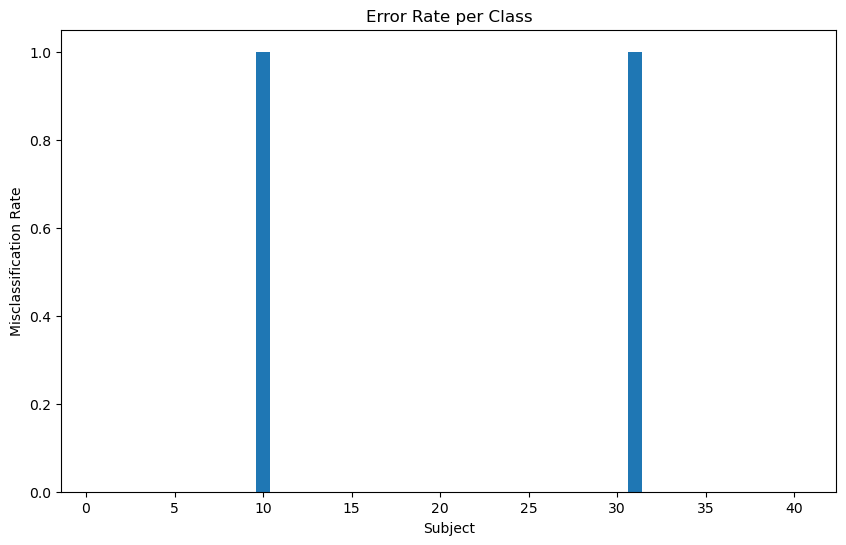

In [280]:

errorRates = []

for label in np.unique(yTest):
    indices = np.where(yTest == label)
    error = np.mean(yPred[indices] != yTest[indices])
    errorRates.append(error)

plt.figure(figsize=(10, 6))
plt.bar(np.unique(yTest), errorRates)
plt.xlabel('Subject')
plt.ylabel('Misclassification Rate')
plt.title('Error Rate per Class')
plt.show()

**Explanation:**

-  we calculate the misclassification rate for each class.
- This helps identify which subjects are more difficult to recognize.


---


<a id="11"></a>
## 11. Cross-Validation and Train-Test Ratios

### Effect of Train-Test Split Ratios

We will see how adjusting the ratio of the train-test split impacts the performance of the model.

We now modify the split ratio between the training set and the testing set to see how changing the ratio of the training data impacts the performance of our face recognition model.

To evaluate our analysis, we're going to try a couple different train-test splits and just follow how the accuracy of our model is trending. Ideally we'd expect in principle as we increase the training set size, the performance of the model should grow and we want to look for this effect in the detail of our implementation.

---


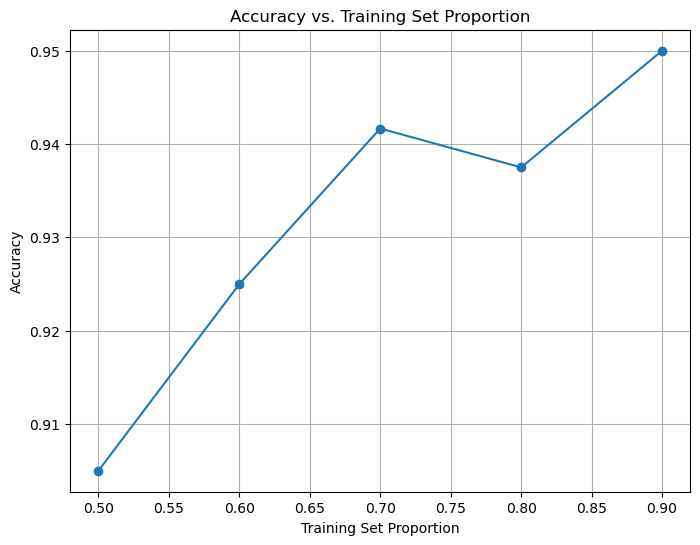

In [281]:
testSizes = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []

for testSize in testSizes:
    XTrainCV, XTestCV, yTrainCV, yTestCV = train_test_split(
        X, y, test_size=testSize, random_state=42, stratify=y
    )
    meanFaceCV = np.mean(XTrainCV, axis=0)
    XTrainCenteredCV = XTrainCV - meanFaceCV
    XTestCenteredCV = XTestCV - meanFaceCV

    pcaModelCV = PCA(n_components=50, svd_solver='randomized', whiten=True)
    pcaModelCV.fit(XTrainCenteredCV)

    XTrainPCACV = pcaModelCV.transform(XTrainCenteredCV)
    XTestPCACV = pcaModelCV.transform(XTestCenteredCV)

    knnClassifierCV = KNeighborsClassifier(n_neighbors=1)
    knnClassifierCV.fit(XTrainPCACV, yTrainCV)
    yPredCV = knnClassifierCV.predict(XTestPCACV)

    accuracy = np.mean(yPredCV == yTestCV)
    accuracies.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot([1 - ts for ts in testSizes], accuracies, marker='o')
plt.xlabel('Training Set Proportion')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Training Set Proportion')
plt.grid(True)
plt.show()


## Explanation:

We vary the test set size from 10% to 50% of the dataset.  
The plot shows how the accuracy changes with the amount of training data.  
Generally, more training data leads to better performance.


## Conclusion

In this project, we have explored the Eigenfaces approach to face recognition in detail. We have implemented each of the steps and seen results that give us insights about:

- **Data Preprocessing** - How to prepare and centre the data for PCA.
- **Computing Eigenfaces**: Applying PCA to extract the principal components of face images.
- **Dimensionality Reduction**: Projecting a high-dimensional dataset into a lower one.
- **Reconstruction**: How reconstruction will depend on the number of principal components.
- **Classification**: Apply k-NN in the Eigenface space for face recognition.
- **Real-Time Recognition**: Providing a function to input a new image and perform face recognition.
- **Analysis**: Evaluating model performance and understanding its limitations.
### Key Takeaways:
- **Explained Variance**: The variation could be explained by only a few principal components.
- **Reconstruction Quality**: More PCs lead to better reconstruction but at the cost of higher complexity.
Recognition Performance The Eigenfaces algorithm is good under controlled conditions but fails for variations of lighting, expressions, and occlusions.
- **Data quantity**: More training data relates to the performance of your model.


### References:
- Turk, M., & Pentland, A. (1991). Face recognition using eigenfaces. Proceedings. 1991 IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 586-591.
- AT&T Laboratories Cambridge. The ORL Database of Faces.